### Imports

In [14]:
%pylab inline
import cPickle
from glob import glob
from nipype.interfaces import afni
from nipype.interfaces.fsl import Level1Design, FEATModel, FILMGLS, FEAT, maths
from nipype.algorithms.modelgen import SpecifyModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node
from os.path import abspath, join
import pandas as pd
import shutil


Populating the interactive namespace from numpy and matplotlib


### Experiment Variables

In [2]:
experiment_dir = abspath('.')
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-s358']

# list of task identifiers
task_list = ['stroop']

# TR of functional images
TR = .68


###  Specify Contrasts

In [3]:
# Contrasts
c1 = ['incongruent','T', ['incongruent'], [1]]
c2 = ['congruent','T', ['congruent'], [1]]
c3 = ['incongruent-congruent','T', ['incongruent','congruent'], [1,-1]]

contrast_list = [c1,c2,c3]

# Set up Nodes

### Specify GLM Model for Stroop Contrasts

In [4]:
# helper function to create bunch
def subjectinfo(subject_id, task, inspect_inputs=False):
    
    from glob import glob
    import numpy as np
    import pandas as pd
    from os.path import join
    from nipype.interfaces.base import Bunch
    from utils.utils import parse_EVs, process_confounds
    
    base_dir = '/home/jovyan/work/output'
    
    # strip "sub" from beginning of subject_id if provided
    subject_id = subject_id.replace('sub-','')
    
    ## Get the Events File
    
    # Read the TSV file and convert to pandas dataframe
    event_file = glob(join(base_dir,
                           'Data',
                           'sub-%s' % subject_id,
                           '*', 'func',
                           '*%s*events.tsv' % task))[0]
    events_df = pd.read_csv(event_file,sep = '\t')

    ## Get the Confounds File (output of fmriprep)
    # Read the TSV file and convert to pandas dataframe
    confounds_file = glob(join(base_dir,
                               'Data',
                               'sub-%s' % subject_id,
                               '*', 'func',
                               '*%s*confounds.tsv' % task))[0]
    regressors, regressor_names = process_confounds(confounds_file)
    
    # set up contrasts
    conditions, onsets, durations, amplitudes = parse_EVs(events_df,'stroop')
    
    subjectinfo = Bunch(conditions=conditions,
                        onsets=onsets,
                         durations=durations,
                         amplitudes=amplitudes,
                         tmod=None,
                         pmod=None,
                         regressor_names=regressor_names,
                         regressors=regressors.T.tolist())
    if inspect_inputs==True:
        regressors_df = pd.DataFrame(regressors, columns = regressor_names)
        return events_df, regressors_df
    else:
        return subjectinfo  # this output will later be returned to infosource



View one events file used in subject info

In [5]:
bunch = subjectinfo('s358','stroop')
events_df,confounds_df = subjectinfo('s358','stroop',True)
events_df.head() 

,onset,duration,response_time,block_duration,correct,experiment_exp_id,key_press,stim_color,stim_word,timing_post_trial,trial_num,trial_type,worker_id
0,3.510,1.5,0.807,2272.0,1.0,stroop,71,blue,red,0.0,0.0,incongruent,s358
1,5.785,1.5,0.458,2000.0,1.0,stroop,71,blue,red,0.0,1.0,incongruent,s358
2,7.786,1.5,0.412,2000.0,1.0,stroop,71,blue,blue,0.0,2.0,congruent,s358
3,9.788,1.5,0.499,2000.0,1.0,stroop,82,green,green,0.0,3.0,congruent,s358
4,11.791,1.5,0.508,2000.0,1.0,stroop,71,blue,green,0.0,4.0,incongruent,s358


### Specify Input and Output Stream

In [6]:
# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id', 'task'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'task',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': join('Data', '{subject_id}','*','func',
                         '*{task}*preproc.nii.gz'),
            'mask': join('Data', '{subject_id}','*','func',
                         '*{task}*brainmask.nii.gz')}
selectfiles = Node(SelectFiles(templates,
                               base_directory = experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory = experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', ''),
                ('fstat', 'FSTST'),
                ('run0.mat', 'designfile.mat')]
datasink.inputs.substitutions = substitutions

### Model Specification

In [7]:
# mask and blur
masker = Node(maths.ApplyMask(),name='masker')

# SpecifyModel - Generates FSL-specific Model
modelspec = Node(SpecifyModel(input_units='secs',
                              time_repetition=TR,
                              high_pass_filter_cutoff=80),
                 name="modelspec")

# Level1Design - Generates an FSL design matrix
level1design = Node(Level1Design(bases={'dgamma':{'derivs': True}},
                                 interscan_interval=TR,
                                 model_serial_correlations=True),
                    name="level1design")

# FEATmodel
level1model = Node(FEATModel(), name="FEATModel")

# FILMGLs
# smooth_autocorr, check default, use FSL default
filmgls = Node(FILMGLS(), name="FILMGLS")

# Run as separate nodes

Useful for debugging

# Workflow

In [8]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = join(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('task', 'task')]),
                    (infosource, getsubjectinfo, [('subject_id','subject_id'),
                                                 ('task', 'task')]),
                    (selectfiles, masker, [('func','in_file'),
                                           ('mask', 'mask_file')]),
                    (getsubjectinfo, modelspec, [('subject_info','subject_info')]),
                    (masker, modelspec, [('out_file', 'functional_runs')]),
                    (modelspec, level1design, [('session_info','session_info')]),
                    (infosource, level1design, [('contrasts','contrasts')]),
                    (level1design, level1model, [('ev_files', 'ev_files'),
                                                 ('fsf_files','fsf_file')]),
                    (masker, filmgls, [('out_file', 'in_file')]),
                    (level1model, filmgls, [('design_file', 'design_file'),
                                            ('con_file', 'tcon_file'),
                                            ('fcon_file', 'fcon_file')]),
                    (level1model, datasink, [('design_file', '1stLevel.@design_file')]),
                    (filmgls, datasink, [('zstats', '1stLevel.@Z'),
                                        ('fstats', '1stLevel.@F'),
                                        ('tstats','1stLevel.@T'),
                                        ('param_estimates,1stLevel.@param_estimates')])
                    ])


### Run the Workflow


In [9]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

170524-20:19:09,863 workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging']
170524-20:19:09,879 workflow INFO:
	 Running in parallel.
170524-20:19:09,884 workflow INFO:
	 Executing: getsubjectinfo.a0 ID: 0
170524-20:19:09,887 workflow INFO:
	 Executing: selectfiles.a0 ID: 1
170524-20:19:09,890 workflow INFO:
	 Executing node getsubjectinfo.a0 in dir: /home/jovyan/work/output/workingdir/l1analysis/_subject_id_sub-s358_task_stroop/getsubjectinfo
170524-20:19:09,895 workflow INFO:
	 Executing node selectfiles.a0 in dir: /home/jovyan/work/output/workingdir/l1analysis/_subject_id_sub-s358_task_stroop/selectfiles
170524-20:19:09,955 workflow INFO:
	 [Job finished] jobname: selectfiles.a0 jobid: 1
170524-20:19:09,962 workflow INFO:
	 Executing: masker.a0 ID: 2
170524-20:19:09,982 workflow INFO:
	 Executing node masker.a0 in dir: /home/jovyan/work/output/workingdir/l1analysis/_subject_id_sub-s358_task_stroop/masker
170524-20:19:10,6 workflow INFO:
	 Running: fslmaths /

### Visualize Workflow

In [10]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)
# Visualize the graph
from IPython.display import Image
graph_file=join(l1analysis.base_dir, 'l1analysis', 'graph.dot.png')
Image(graph_file)
try:
    shutil.move(graph_file, 'l1analysis')
except shutil.Error:
    continue
# remove working directory
shutil.rmtree(working_dir)

170524-20:58:19,8 workflow INFO:
	 Converting dotfile: /home/jovyan/work/output/workingdir/l1analysis/graph.dot to png format


IOError: [Errno 2] No such file or directory: u'/home/jovyan/work/output/workingdir/l1analysis/graph.dot.png'

### Visualize Design Matrix

In [ ]:
!tree datasink/1stLevel/sub*


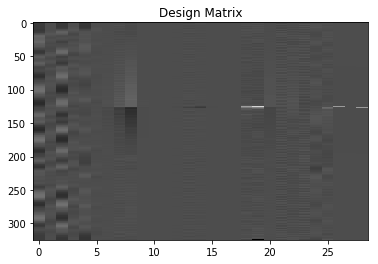

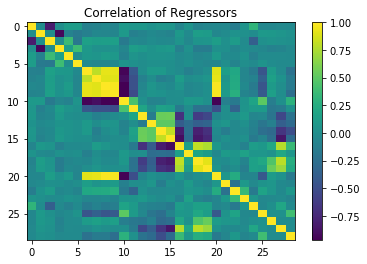

"\n# show first regressors\nplt.figure(figsize=[20,8])\nplt.plot(desmtx[:,0],'b', label=subject_info.conditions[0])\nplt.plot(desmtx[:,2],'r', label=subject_info.conditions[1])\nfor i in subject_info.onsets[0]:\n    plt.axvline(i/.68, ymin=0, ymax=.1)\nfor i in subject_info.onsets[1]:\n    plt.axvline(i/.68, ymin=0, ymax=.1, c='r')\nplt.legend()\nplt.title('Congruent/Incongruent Regressors')\n"

In [11]:
design_file = glob(join(experiment_dir,'datasink','1stLevel','sub-s358_task_stroop','designfile.mat'))[0]
desmtx=numpy.loadtxt(design_file, skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')
plt.title('Design Matrix')
plt.show()
cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()
plt.title('Correlation of Regressors')
plt.show()
"""
# show first regressors
plt.figure(figsize=[20,8])
plt.plot(desmtx[:,0],'b', label=subject_info.conditions[0])
plt.plot(desmtx[:,2],'r', label=subject_info.conditions[1])
for i in subject_info.onsets[0]:
    plt.axvline(i/.68, ymin=0, ymax=.1)
for i in subject_info.onsets[1]:
    plt.axvline(i/.68, ymin=0, ymax=.1, c='r')
plt.legend()
plt.title('Congruent/Incongruent Regressors')
"""

### Visualize Results

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


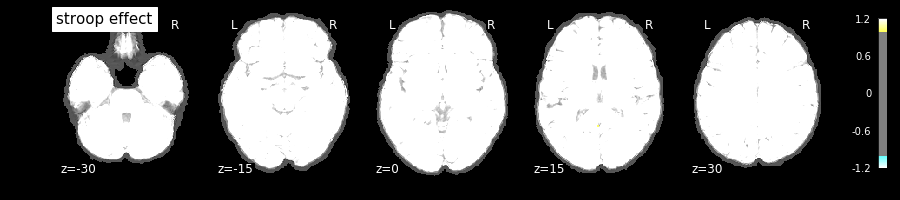

In [12]:
from nilearn.plotting import plot_stat_map
from nilearn.image import smooth_img

anatimg = glob(join(experiment_dir,'Data','sub-s358','anat','*T1w*MNI*preproc*'))[0]
contrast_img = glob(join(experiment_dir,'datasink','1stLevel','sub-s358_task_stroop','zstat3.nii.gz'))[0]
plot_stat_map(smooth_img(contrast_img, 8), title='stroop effect',
              bg_img=anatimg, threshold=1, display_mode='z', cut_coords=(-30, -15, 0, 15, 30), dim=-1)

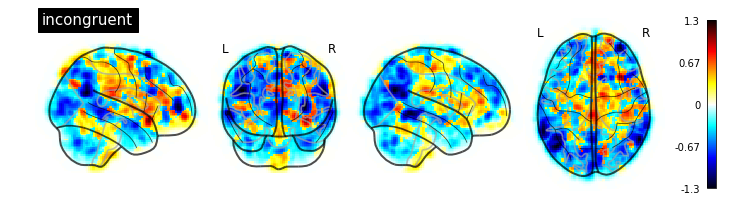

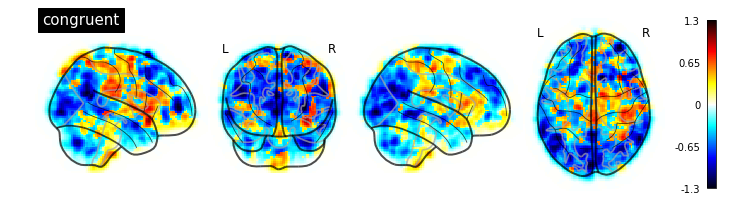

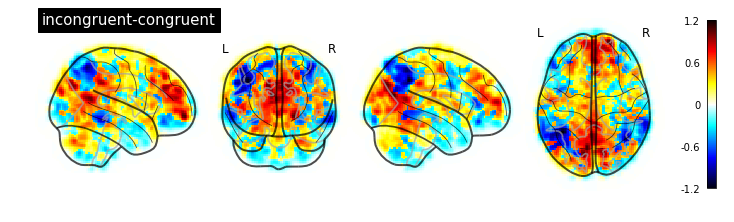

In [33]:
import nilearn.plotting
import nilearn.image
titles = ['incongruent', 'congruent', 'incongruent-congruent']
for contrast in [1,2,3]:
    contrast_img = glob(join(experiment_dir,'datasink','1stLevel','sub-s358_task_stroop','zstat%d.nii.gz' % contrast))[0]
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(contrast_img, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=0, 
                                      title=titles[contrast-1])